In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [2]:
train_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import cv2

class dataset(Dataset) :
    def __init__(self, label, img) :
        self.label = np.array(label)
        img = img / 255.0
        self.img = np.array(img).reshape(-1, 28, 28, 1)
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
    def __len__(self) :
        return len(self.img)
    
    def __getitem__(self, index) :
        label = self.label[index]
        img = self.img[index]
        img = self.transform(img)
        
        label = torch.LongTensor([label])
        img = img.float()
        
        return img, label


train_x = train_df.drop(['label'], axis = 1)
train_y = train_df['label']

test_x = test_df.drop(['label'], axis = 1)
test_y = test_df['label']

train_data = dataset(train_y, train_x)
train_data = DataLoader(train_data, batch_size = 64, shuffle = True)

test_data = dataset(test_y, test_x)
test_data = DataLoader(test_data, batch_size = 64, shuffle = True)

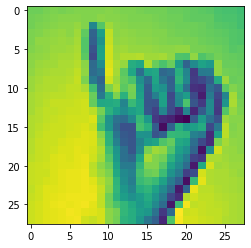

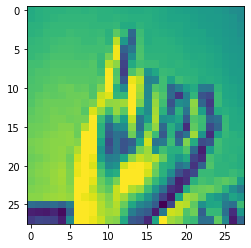

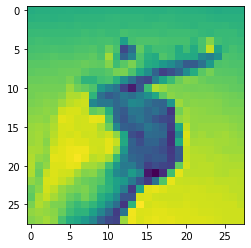

In [4]:
import matplotlib.pyplot as plt

for x, y in train_data :
    plt.imshow(x[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(x[1].permute(1, 2, 0))
    plt.show()
    plt.imshow(x[2].permute(1, 2, 0))
    plt.show()
    break

In [5]:
#num of labels
classes = 26

In [7]:
!pip install torchsummary

In [34]:
import torch.nn as nn
from torchsummary import summary

class cnnModel(nn.Module) :
    def __init__(self, classes) :
        super().__init__()
        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #14
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #7
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #3
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )
        
        self.dnnModel = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, classes),
        )
        
    def forward(self, x) :
        output = self.cnnModel(x)
        output = output.squeeze()
        output = self.dnnModel(output)
        return output
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnnModel(classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
         MaxPool2d-8            [-1, 128, 4, 4]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                   [-1, 64]           8,256
        LeakyReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 32]           2,080
        LeakyReLU-13                   [-1, 32]               0
           Linear-14                   

In [35]:
from tqdm.notebook import tqdm

epoch_num = 100
model.train()

for epoch in range(epoch_num) :
    epoch_loss = 0
    epoch_acc = 0
    for img, label in tqdm(train_data) :
        img = img.to(device)
        label = label.to(device).reshape(-1)
        
        predict = model(img)
        
        loss = criterion(predict, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        correct_prediction = torch.argmax(predict, 1) == label
        correct_prediction = correct_prediction.sum()
        epoch_acc += correct_prediction / img.shape[0]
        
    epoch_loss = epoch_loss / len(train_data)
    epoch_acc = epoch_acc / len(train_data)
    
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, epoch_num, epoch_loss, epoch_acc))
    
    if epoch_acc > 0.99 and epoch_loss < 0.1 :
        print('early stop')
        break

  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 1/100,   loss : 2.80835,    acc : 0.13284


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 2/100,   loss : 1.54777,    acc : 0.44710


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 3/100,   loss : 0.91234,    acc : 0.67285


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 4/100,   loss : 0.54730,    acc : 0.80401


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 5/100,   loss : 0.34073,    acc : 0.87693


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 6/100,   loss : 0.18997,    acc : 0.93615


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 7/100,   loss : 0.13446,    acc : 0.95644


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 8/100,   loss : 0.07858,    acc : 0.97735


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 9/100,   loss : 0.04492,    acc : 0.98845


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 10/100,   loss : 0.05392,    acc : 0.98317


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch : 11/100,   loss : 0.02819,    acc : 0.99250
early stop


  0%|          | 0/113 [00:00<?, ?it/s]

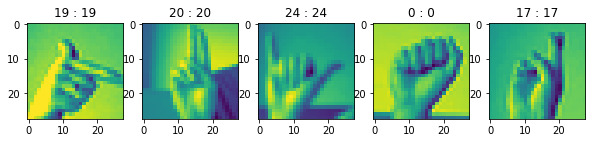

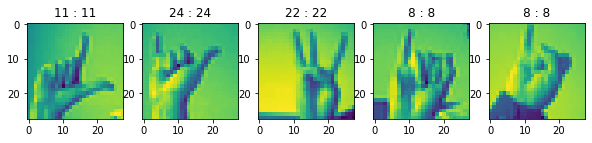

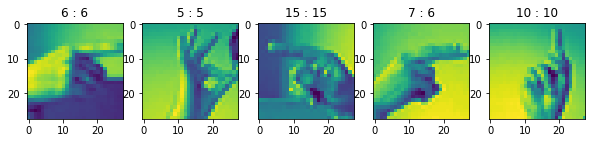

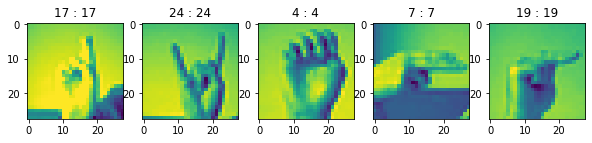

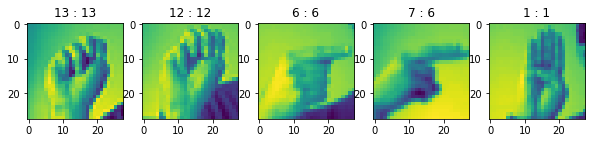

loss : 0.34646,    acc : 0.90639


In [36]:
import warnings

warnings.filterwarnings('ignore')
model.eval()

valid_loss = 0
valid_acc = 0
cnt = 0 #show validate result for 5 times

for img, label in tqdm(test_data) :
    img = img.to(device)
    label = label.to(device).reshape(-1)
    
    predict = model(img)
    
    loss = criterion(predict, label)
    
    valid_loss += loss
    correct_prediction = torch.argmax(predict, 1) == label
    correct_prediction = correct_prediction.sum()
    valid_acc += correct_prediction / img.shape[0]
    
    if cnt < 5 :
        fig = plt.figure(figsize = (10, 10))
        for i in range(5) :
            img_i = img[i].to('cpu').numpy()
            img_i = img_i.transpose(1, 2, 0)
            p = torch.argmax(predict[i]).item()
            subplot = fig.add_subplot(1, 5, i+1)
            subplot.set_title(str(label[i].item()) + ' : ' + str(p))
            subplot.imshow(img_i)
        plt.show()
        cnt += 1
        
valid_loss = valid_loss / len(test_data)
valid_acc = valid_acc / len(test_data)

print('loss : {:.5f},    acc : {:.5f}'.format(valid_loss, valid_acc))